# The control of human psycho-affective stability using differential equations

In [97]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Functions 

### Define the system

In [98]:
def romeo_juliet_system(t, variables, a, b, c, d):
    """
    Defines the linear system modeling Romeo and Juliet's emotions.
    dx/dt = a*x + b*y
    dy/dt = c*x + d*y
    """
    x, y = variables
    dxdt = a * x + b * y
    dydt = c * x + d * y
    return [dxdt, dydt]

### Equilibrium and stability computations

In [99]:
def analyze_stability(a, b, c, d):
    """
    Computes determinant, Jacobian, eigenvalues and interprets stability.
    """
    J = np.array([[a, b], [c, d]])
    delta = a * d - b * c
    eigenvalues, eigenvectors = np.linalg.eig(J)

    print(f"Jacobian:\n{J}")
    print(f"Determinant Δ = {delta:.2f}")
    print(f"Eigenvalues = {eigenvalues}\n")

    if np.isreal(eigenvalues).all():  # Real eigenvalues
        if np.sign(eigenvalues[0]) == np.sign(eigenvalues[1]):
            if np.all(eigenvalues < 0):
                return "Stable node"
            elif np.all(eigenvalues > 0):
                return "Unstable node"
        else:
            return "Saddle point (unstable)"
    else:
        real_part = np.real(eigenvalues[0])
        if real_part < 0:
            return "Stable spiral"
        elif real_part > 0:
            return "Unstable spiral"
        else:
            return "Center (neutral oscillations)"

### Function to modelise/simulate

In [100]:
def simulate_system(a, b, c, d, x0, y0):
    """
    Solves the system numerically 
    """
    t_span = (0, 70)
    t_eval = np.linspace(*t_span, 500)
    sol = solve_ivp(romeo_juliet_system, t_span, [x0, y0], args=(a, b, c, d), t_eval=t_eval)
    return sol

### The function to plot

In [101]:
def plot_evolution(sol, title):
    """
    Plots the emotional evolution of Romeo and Juliet over time.
    """
    plt.figure(figsize=(7, 4))
    plt.plot(sol.t, sol.y[0], label="Romeo (x)", color='blue')
    plt.plot(sol.t, sol.y[1], label="Juliet (y)", color='red')

    plt.xlabel("Time")
    plt.ylabel("Emotions")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### THE function

In [102]:
def run_scenario(name, a, b, c, d, x0, y0):
    """
    Runs one full scenario: stability + simulation + plot.
    """
    print("\n----------------------------------------")
    print(f"SCENARIO: {name}")
    print(f"Parameters: a={a}, b={b}, c={c}, d={d}")
    
    stability = analyze_stability(a, b, c, d)
    print(f"→ Stability type: {stability}")
    
    sol = simulate_system(a, b, c, d, x0, y0)
    print(f"Final state: x={sol.y[0, -1]:.3f}, y={sol.y[1, -1]:.3f}")
    
    plot_evolution(sol, f"{name} – {stability}")

How to use it : copy and paste the following code :


In [103]:
#scenarios = {
#    "scenario 1": (0, 0, 0, 0),
#    "scenario 2": (0, 0, 0, 0),
#    } # Add scenarios as needed

# Run them all
#for name, params in scenarios.items():
#    run_scenario(name, *params, x0=0.1, y0=-0.1)

# Test

Parameters **_a_**, **_b_**, **_c_**, **_d_** quantify Romeo’s romantic style and Juliet's romantic style as follows :


- **_a_** --> how Romeo is encouraged by his feelings
- **_b_** --> how Romeo is encouraged by Juliet’s feelings.
- **_c_** --> how Juliet is encouraged by Romeo's feelings 
- **_d_** --> how Juliet is encouraged by her feelings


## Mutual and increasing love scenarios

As presented in figures 1 and 2 in the article, you will find below mutual and increasing love in which Romeo's feelings are a bit more intense. The important parameters here are **_b_** and **_c_**. In other words, this configuration can be obtain by using only the simple model. Here, we represent the (tres petite) discrepancy of feelings between Romeo and Juliette by setting **_b > c_**


----------------------------------------
SCENARIO: Figure 1
Parameters: a=0, b=0.2, c=0.05, d=0
Jacobian:
[[0.   0.2 ]
 [0.05 0.  ]]
Determinant Δ = -0.01
Eigenvalues = [ 0.1 -0.1]

→ Stability type: Saddle point (unstable)
Final state: x=1644.600, y=822.300


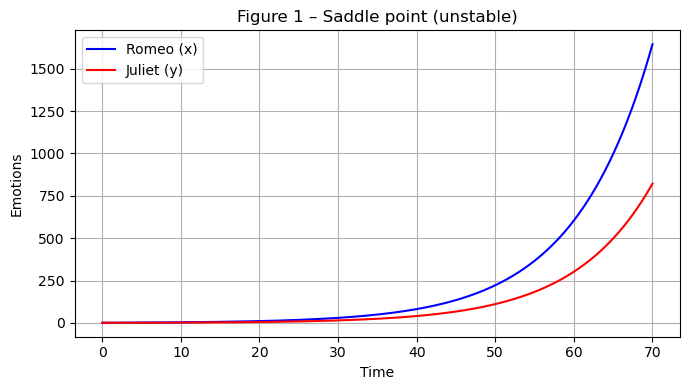


----------------------------------------
SCENARIO: Figure 2
Parameters: a=0, b=0.2, c=0.1, d=0
Jacobian:
[[0.  0.2]
 [0.1 0. ]]
Determinant Δ = -0.02
Eigenvalues = [ 0.14142136 -0.14142136]

→ Stability type: Saddle point (unstable)
Final state: x=24034.545, y=16994.990


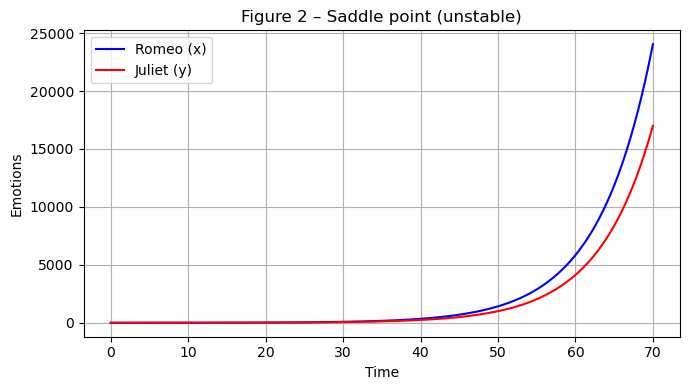


----------------------------------------
SCENARIO: Fig. 3: We have an endless cycle of love versus strife
Parameters: a=-0.1, b=0.1, c=-0.1, d=-0.1
Jacobian:
[[-0.1  0.1]
 [-0.1 -0.1]]
Determinant Δ = 0.02
Eigenvalues = [-0.1+0.1j -0.1-0.1j]

→ Stability type: Stable spiral
Final state: x=0.001, y=0.000


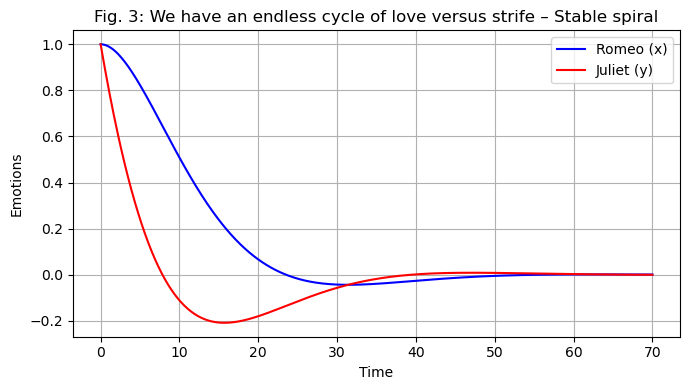

In [ ]:
scenarios = {
    "Figure 1": (0, 0.2, 0.05, 0),
    "Figure 2": (0, 0.2, 0.1, 0),
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=1, y0=1)


----------------------------------------
SCENARIO: Fig. 6: We have a cold relationship between the two lovers
Parameters: a=0.1, b=0.2, c=-0.2, d=-0.2
Jacobian:
[[ 0.1  0.2]
 [-0.2 -0.2]]
Determinant Δ = 0.02
Eigenvalues = [-0.05+0.13228757j -0.05-0.13228757j]

→ Stability type: Stable spiral
Final state: x=-0.088, y=-0.784


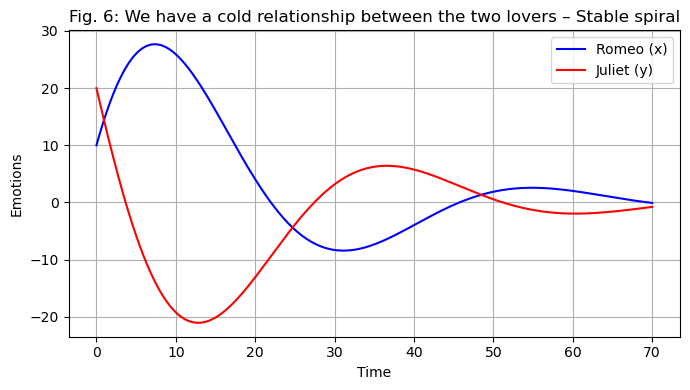

In [108]:
scenarios = {
    "Fig. 6: We have a cold relationship between the two lovers": (0.1, 0.2, -0.2, -0.2),
    }

# Run them all
for name, params in scenarios.items():
    run_scenario(name, *params, x0=10, y0=20)